In [195]:
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from diffuse.noise_scheduler import NoiseScheduler
from dataclasses import dataclass
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from diffuse.utils import image_grid
from torch.optim import Adam
from diffuse.models.unet2 import UNet
from diffuse.models.mlp import MLP
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

@dataclass
class Config:
    experiment_name: str = 'base'
    dataset: str = 'cifar10'
    train_batch_size: int = 256
    eval_batch_size: int = 1000
    num_epochs: int = 20
    learning_rate: float = 3e-4

    # noise
    num_timesteps: int = 1000
    beta_schedule: str = "log2"
    beta_start: float = .0001
    beta_end:float = .02

    # data
    image_size:int = 28
    channels:int = 3
    # embedding_size: int = 128
    # hidden_size: int = 128
    # hidden_layers: int = 3
    # time_embedding: str = "sinusoidal"
    # input_embedding: str = "sinusoidal"
    # save_images_step: int = 1
c = Config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
# load dataset from the hub
dataset = load_dataset(c.dataset)
# batch_size = 256

noise_scheduler = NoiseScheduler(num_timesteps=c.num_timesteps, beta_schedule=c.beta_schedule,
                                 beta_start=c.beta_start,beta_end=c.beta_end)

In [197]:
# define image transformations (e.g. using torchvision)
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

reverse_transform = transforms.Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: rearrange(t, 'c h w -> h w c')), 
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

# define function
def t(examples):
   examples["pixel_values"] = [transform(image) for image in examples["img"]]
   del examples["img"]

   return examples

transformed_dataset = dataset.with_transform(t).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=c.batch_size, shuffle=True)
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


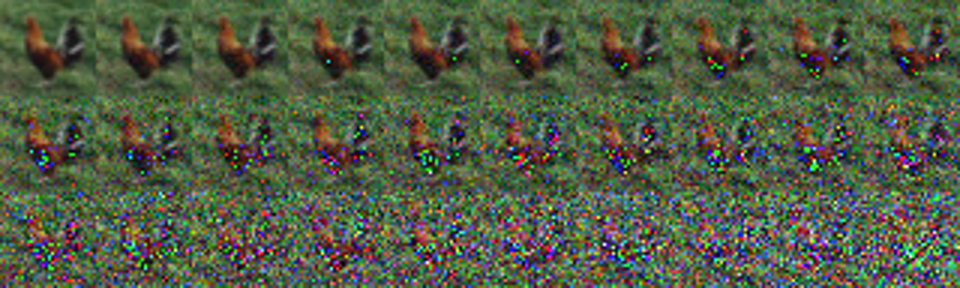

In [202]:
i=5
x_0 = dataset.with_transform(t).remove_columns("label")['train'][i:i+2]['pixel_values']
x_0 = torch.stack(x_0,0)
x = x_0.repeat_interleave(c.num_timesteps,0)
timesteps = torch.arange(c.num_timesteps).repeat_interleave(2,0)
x_noised = noise_scheduler.add_noise(x, torch.randn_like(x),timesteps)
z = [reverse_transform(x_) for x_ in x_noised]
image_grid(list(z[:c.num_timesteps])[::30],cols=10, resize=(100,100))

In [211]:
device = "cuda"
model = UNet(image_channels=3, n_blocks=2).to(device)
# model = MLP().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=c.learning_rate)

In [221]:
torch.manual_seed(2)

global_step = 0
losses = []
epoch_to_samples = dict()

print("Training model...")

# one_batch = next(iter(dataloader))
for epoch in range(10):#c.num_epochs):
    model.train()
    for step, batch in enumerate(iter(dataloader)):
        batch = batch['pixel_values']
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy.to(device), timesteps.to(device))
        loss = F.mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(float(loss.detach().item()))

        # progress_bar.set_postfix(**logs)
        if global_step % 2 == 0:
            loss = sum(losses[-30:])/min(30,len(losses)) # running loss
            print(f'e{epoch}|s{global_step} loss={loss:.6f}')

        global_step += 1
    # if epoch % c.save_images_step == 0 or epoch == c.num_epochs - 1:
    #     epoch_to_samples[epoch]=model.sample(noise_scheduler)

Training model...
e0|s0 loss=0.129401
e0|s2 loss=0.125141
e0|s4 loss=0.121465
e0|s6 loss=0.122167
e0|s8 loss=0.121765
e0|s10 loss=0.121311
e0|s12 loss=0.120040
e0|s14 loss=0.116899
e0|s16 loss=0.117113
e0|s18 loss=0.117188
e0|s20 loss=0.116536
e0|s22 loss=0.116595
e0|s24 loss=0.116608
e0|s26 loss=0.115800
e0|s28 loss=0.115996
e0|s30 loss=0.115467
e0|s32 loss=0.114049
e0|s34 loss=0.114224
e0|s36 loss=0.114545
e0|s38 loss=0.113972
e0|s40 loss=0.114041
e0|s42 loss=0.113709
e0|s44 loss=0.114993
e0|s46 loss=0.114588
e0|s48 loss=0.115012
e0|s50 loss=0.115119
e0|s52 loss=0.115720
e0|s54 loss=0.115901
e0|s56 loss=0.116148
e0|s58 loss=0.115576
e0|s60 loss=0.116531
e0|s62 loss=0.116769
e0|s64 loss=0.116133
e0|s66 loss=0.115396
e0|s68 loss=0.115950
e0|s70 loss=0.115547
e0|s72 loss=0.115248
e0|s74 loss=0.115331
e0|s76 loss=0.115897
e0|s78 loss=0.114373
e0|s80 loss=0.113909
e0|s82 loss=0.112725
e0|s84 loss=0.112441
e0|s86 loss=0.112355
e0|s88 loss=0.112992
e0|s90 loss=0.112081
e0|s92 loss=0.113002


In [222]:
# with torch.no_grad():
#     for k,p in model.named_parameters():
#         if p is not None:
#             d = p.detach().cpu().numpy()
#             g = p.grad.detach().cpu().numpy()
#             # print(k,d.mean(),d.std(),np.abs(d).max())
#             print(k,g.mean(),g.std(),np.abs(g).max())
#             # pass
#         else:
#             print(k)

In [223]:
epoch_to_samples[epoch]=noise_scheduler.sample(model,(2,)+batch.shape[1:])

In [224]:
s = [reverse_transform(epoch_to_samples[epoch][t][1]) for t in range(c.num_timesteps)]
# reverse_transform(s).resize((300,300))

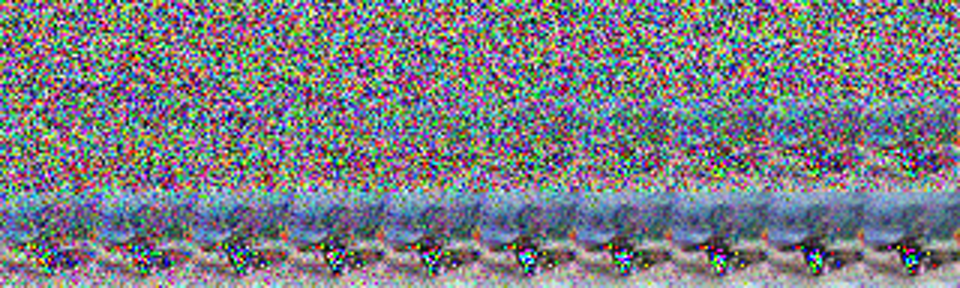

In [225]:
image_grid(s[::30], 10, (100,100))